In [1]:
import librosa
import numpy as np
import scipy.signal
from scipy.signal.windows import hamming

#### Load and segments the audio files 

In [2]:
SR  = 22050
DUR = 4
WINDOW = hamming(SR * DUR)

In [3]:
import glob
segments = []
frame_length = SR * DUR
hop_length   = frame_length
for wavfile in glob.iglob("./*_wav/*.wav"):
    y, _ = librosa.load(wavfile, mono=True, sr=SR)
    y = y / np.amax(np.abs(y))
    frames = librosa.util.frame(
        y, 
        frame_length=frame_length, 
        hop_length=hop_length
    )
    segments += [frames[:, i] * WINDOW for i in range(frames.shape[-1])]
    print("parsed segment: " + wavfile)
    
print(len(segments))

parsed segment: ./simon_wav/US_DJH_Drum_118_bounds_KICK.wav
parsed segment: ./simon_wav/US_DJH_Key_118_absent_Abm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_earl_Cm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_merch_Dm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_anti_F#.wav
parsed segment: ./simon_wav/US_DJH_Key_shine_Eb.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_earth_KICK.wav
parsed segment: ./simon_wav/US_DJH_Key_118_cuz_Abm.wav
parsed segment: ./simon_wav/US_DJH_Key_oyster_Cm.wav
parsed segment: ./simon_wav/US_DJH_Key_listen_Cm.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_cuz_KICK.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_inc_SNARE.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_call_FULL.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_cuz_FULL.wav
parsed segment: ./simon_wav/US_DJH_Key_120_dego_Bm.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_dont_HATS.wav
parsed segment: ./simon_wav/US_DJH_Synth_118_lightpad_Dm.wav
parsed segment: ./simon_wav/US_DJH_Drum_

parsed segment: ./dance_wav/mPO5.wav
parsed segment: ./dance_wav/mLH2.wav
parsed segment: ./dance_wav/mJB2.wav
parsed segment: ./dance_wav/mWA5.wav
parsed segment: ./dance_wav/mMH3.wav
parsed segment: ./dance_wav/mLH0.wav
parsed segment: ./dance_wav/mLO0.wav
parsed segment: ./dance_wav/mPO0.wav
parsed segment: ./dance_wav/mBR0.wav
parsed segment: ./dance_wav/mJB5.wav
parsed segment: ./dance_wav/mLO1.wav
parsed segment: ./dance_wav/mMH4.wav
parsed segment: ./dance_wav/mPO2.wav
parsed segment: ./dance_wav/mKR1.wav
parsed segment: ./dance_wav/mLO3.wav
parsed segment: ./dance_wav/mJS3.wav
parsed segment: ./dance_wav/mPO4.wav
parsed segment: ./dance_wav/mJB4.wav
parsed segment: ./dance_wav/mWA4.wav
parsed segment: ./dance_wav/mJS5.wav
parsed segment: ./dance_wav/mHO2.wav
parsed segment: ./dance_wav/mLH5.wav
parsed segment: ./dance_wav/mBR2.wav
parsed segment: ./dance_wav/mLO5.wav
parsed segment: ./dance_wav/mMH0.wav
parsed segment: ./dance_wav/mPO1.wav
parsed segment: ./dance_wav/mWA0.wav
p


#### Extract STFTs from audio segments (4sec) 

In [4]:
NFFT        = 1024
OVERLAP     = 512
REFERENCE   = 100.

In [5]:
ndata        = len(segments)
max_rows     = int(np.ceil(DUR * SR / OVERLAP))
max_cols     = int(NFFT // 2 + 1)
nchannels    = 2

stft_dataframe = np.zeros((
        ndata, 
        max_cols, 
        max_rows, 
        nchannels
)) 

thresh = 1e-4

for i, seg in enumerate(segments):
    stft = librosa.stft(y          = seg, 
                        n_fft      = NFFT, 
                        hop_length = OVERLAP, 
                        window     = hamming)
    ixs = np.abs(stft) <= thresh
    stft[ixs] = 0. + 0.j
    stft_dataframe[i, :, :, 0] = stft.real
    stft_dataframe[i, :, :, 1] = stft.imag
    
print(stft_dataframe.shape)

(806, 513, 173, 2)


In [6]:
stft_frames = np.reshape(stft_dataframe, newshape=(-1, max_cols, nchannels))
print(stft_frames.shape)

(139438, 513, 2)


#### Sanity Check 

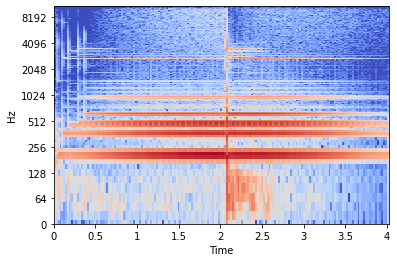

In [8]:
Sdf = stft_frames[173:346, :, :]
Sdf = np.reshape(Sdf, newshape=(max_cols, max_rows, nchannels))
S = np.zeros(Sdf.shape[:-1], dtype=np.complex)
S.real = Sdf[:, :, 0]
S.imag = Sdf[:, :, 1]
M = np.abs(S)
M_db = librosa.amplitude_to_db(M)

import librosa.display
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(M_db, sr=SR,
                               y_axis='log', x_axis='time', ax=ax)

y_ = librosa.istft(stft_matrix = S, 
                   hop_length  = OVERLAP, 
                   window      = hamming)

import IPython.display as ipd
ipd.display(ipd.Audio(y_, rate=SR))

#### Make dataset 

In [9]:
audio_data = {
    "MetaInfo": {
        "SampleRate"  : SR,
        "ClipDuration": DUR,
        "FFTWindow"   : "hamming",
        "Num_fft"     : NFFT,
        "Overlap"     : OVERLAP
    },
    "Data": stft_frames
}

import joblib 
joblib.dump(audio_data, "./dance_wav/audio_spectral_data_stft.pkl", compress=3)

['./dance_wav/audio_spectral_data_stft.pkl']